# ModularSimulator Kalman filter with propeller and simple rudder

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes, ExtendedKalmanModular
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
#from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq
from vessel_manoeuvring_models.extended_kalman_filter import extended_kalman_filter
from vessel_manoeuvring_models.models.propeller import PropellersSystem
import inspect
from sympy.printing import pretty
import statsmodels.api as sm
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.tests")
#time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[07/07/23 13:39:37] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=461549;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=720437;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/07/23 13:39:47] INFO     Kedro project phd                                                      ]8;id=590991;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=433285;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=19316;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=734042;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=8080;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=794679;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=10979;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=317862;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=763056;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=692561;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=154417;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=266018;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.time_series_meta_data' (CSVDataSet)...       ]8;id=204781;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=168237;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=827698;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=977947;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
id = '0'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
rev_guess = 15
data['rev'] = rev_guess

In [5]:
model_simple_rudder = model_loader["MDL_modular"]()
model_complex_rudder = model_loader["VCT_MDL_resistance"]()

In [6]:
propellers = model_complex_rudder.subsystems['propellers']

In [7]:
complex_rudders = model_complex_rudder.subsystems['rudders']
simple_rudders = model_simple_rudder.subsystems['rudders']

In [8]:
df = data.copy()
calculation = propellers.calculate_forces(states_dict=data[model_complex_rudder.states_str], control=data[model_complex_rudder.control_keys], calculation={})
df['thrust'] = calculation['thrust']

## Linearize the complex rudders by fitting the simpler rudders to some data

In [9]:
mean_state = df[list(set(model_simple_rudder.states_str+model_simple_rudder.control_keys + model_complex_rudder.control_keys))].mean()

In [10]:
N = 10
variation = pd.DataFrame(np.tile(mean_state, (10,1)), columns=mean_state.index)
variation['thrust'] = np.linspace(df['thrust'].min(), df['thrust'].max(), N)
variation['delta'] = np.deg2rad(10)
variation['v'] = 0
variation['r'] = 0

df_thrust_variation = pd.DataFrame(complex_rudders.calculate_forces(states_dict=variation[model_complex_rudder.states_str], control=variation[model_complex_rudder.control_keys], calculation=variation[['thrust']].copy()))
df_thrust_variation = pd.concat((variation,df_thrust_variation), axis=1)
df_thrust_variation = df_thrust_variation.loc[:,~df_thrust_variation.columns.duplicated()].copy()

In [11]:
variation

,v,rev,y0,thrust,delta,psi,x0,u,r
0,0,15.0,-4.296501,83.963355,0.174533,3.434649,-94.881643,2.213642,0
1,0,15.0,-4.296501,88.774202,0.174533,3.434649,-94.881643,2.213642,0
2,0,15.0,-4.296501,93.585048,0.174533,3.434649,-94.881643,2.213642,0
3,0,15.0,-4.296501,98.395895,0.174533,3.434649,-94.881643,2.213642,0
4,0,15.0,-4.296501,103.206741,0.174533,3.434649,-94.881643,2.213642,0
5,0,15.0,-4.296501,108.017588,0.174533,3.434649,-94.881643,2.213642,0
6,0,15.0,-4.296501,112.828434,0.174533,3.434649,-94.881643,2.213642,0
7,0,15.0,-4.296501,117.639281,0.174533,3.434649,-94.881643,2.213642,0
8,0,15.0,-4.296501,122.450127,0.174533,3.434649,-94.881643,2.213642,0
9,0,15.0,-4.296501,127.260974,0.174533,3.434649,-94.881643,2.213642,0


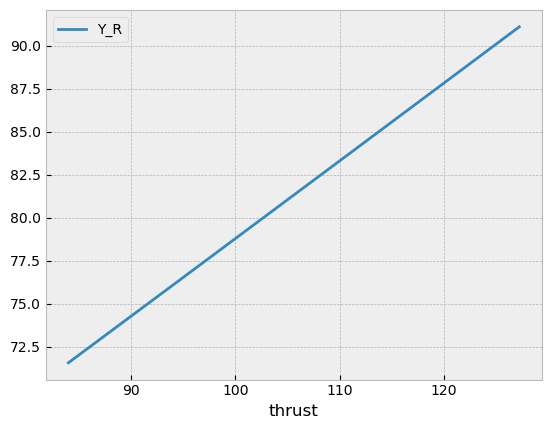

In [12]:
df_thrust_variation.plot(x='thrust',y='Y_R');

In [13]:
N = 10
variation = pd.DataFrame(np.tile(mean_state, (10,1)), columns=mean_state.index)
variation['delta'] = np.linspace(df['delta'].min(), df['delta'].max(), N)
variation['v'] = 0
variation['r'] = 0

df_rudder_variation = pd.DataFrame(complex_rudders.calculate_forces(states_dict=variation[model_complex_rudder.states_str], control=variation[model_complex_rudder.control_keys], calculation=variation[['thrust']].copy()))
df_rudder_variation = pd.concat((variation,df_rudder_variation), axis=1)
df_rudder_variation = df_rudder_variation.loc[:,~df_rudder_variation.columns.duplicated()].copy()

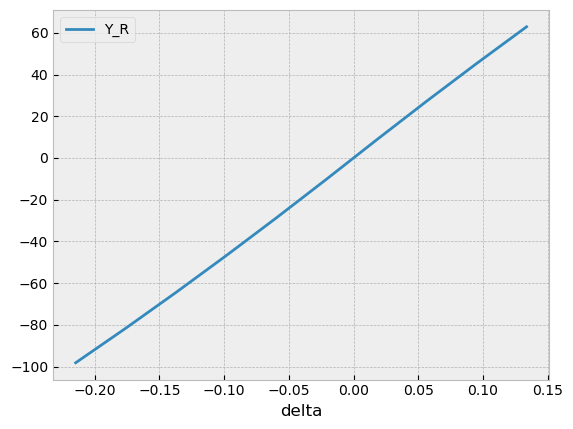

In [14]:
df_rudder_variation.plot(x='delta',y='Y_R');

In [15]:
N = 10
variation = pd.DataFrame(np.tile(mean_state, (10,1)), columns=mean_state.index)
variation['v'] = np.linspace(df['v'].min(),df['v'].max(),N)
variation['delta'] = np.deg2rad(10)
variation['r'] = 0

df_rudder_drift_variation = pd.DataFrame(complex_rudders.calculate_forces(states_dict=variation[model_complex_rudder.states_str], control=variation[model_complex_rudder.control_keys], calculation=variation[['thrust']].copy()))
df_rudder_drift_variation = pd.concat((variation,df_rudder_drift_variation), axis=1)
df_rudder_drift_variation = df_rudder_drift_variation.loc[:,~df_rudder_drift_variation.columns.duplicated()].copy()

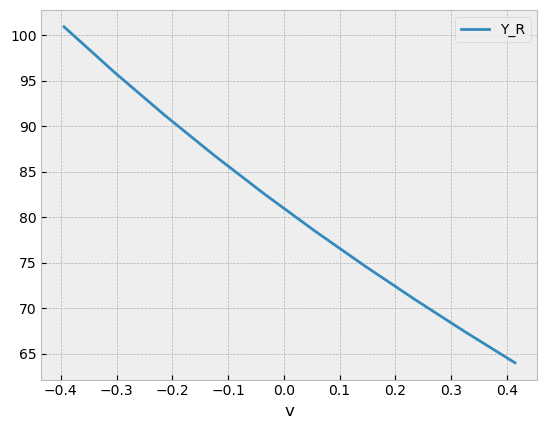

In [16]:
df_rudder_drift_variation.plot(x='v',y='Y_R');

In [17]:
simple_rudders.equations['X_R']

Eq(X_R, X_{deltadelta}*delta**2)

In [18]:
simple_rudders.equations['Y_R']

Eq(Y_R, Y_{delta}*delta + Y_{thrustdelta}*delta*thrust + Y_{vvdelta}*delta*v**2)

In [19]:
simple_rudders.equations['Y_R'].subs([
    (p.Ydelta,0),
    (p.Yvvdelta,0),    
])

Eq(Y_R, Y_{thrustdelta}*delta*thrust)

In [20]:
simple_rudders.equations['Y_R'].subs([
            (v,0),  
        ])

Eq(Y_R, Y_{delta}*delta + Y_{thrustdelta}*delta*thrust)

In [21]:
regression_pipeline = {

    'xdeltadelta': {
        'eq': simple_rudders.equations['X_R'],
        'data':df_rudder_variation,
        'const':True,
    },
    
    'ytd': {
        'eq': simple_rudders.equations['Y_R'].subs([
            (p.Ydelta,0),
            (p.Yvvdelta,0),    
        ]),
        'data':df_thrust_variation,
        'const':True,
    },
    
    'ntd': {
        'eq': simple_rudders.equations['N_R'].subs([
            (p.Ndelta,0),
            (p.Nvvdelta,0),    
        ]),
        'data':df_thrust_variation,
        'const':True,
    },
    
    'yd': {
        'eq': simple_rudders.equations['Y_R'].subs([
            (v,0),  
        ]),
        'data':df_rudder_variation,
    },
    
    'nd': {
        'eq': simple_rudders.equations['N_R'].subs([
            (v,0),  
        ]),
        'data':df_rudder_variation,
    },
    
}

In [22]:
models = {}
exclude_parameters={}
new_parameters = {}
for name, regression in regression_pipeline.items():
    eq = regression['eq']
    if eq.rhs == 0:
        print(f'skipping:{name}')
        continue 
    
    label = regression.get('label',eq.lhs)
    eq_to_matrix = DiffEqToMatrix(eq, label=label, base_features=[u,v,r,thrust,delta], exclude_parameters=exclude_parameters)
        
    data = regression['data'].copy()
    U_ = np.sqrt(data['u']**2 + data['v']**2)        
    data_prime = model_complex_rudder.prime_system.prime(data, U=U_)    
    
    assert len(data) > 0
    key = eq_to_matrix.acceleration_equation.lhs.name
    X,y = eq_to_matrix.calculate_features_and_label(data=data_prime, y=data_prime[key])
    const = regression.get('const',False)
    if const:
        X['const'] = 1
    
    if len(X.columns)==0:
        print(f'skipping:{name}')
        continue
    
    ols = sm.OLS(y,X)
    models[name] = ols_fit = ols.fit()
    new_parameters.update(ols_fit.params)
    exclude_parameters.update(new_parameters)

In [23]:
new_parameters['Yvvdelta']=0
new_parameters['Nvvdelta']=0


In [24]:
exclude_parameters

{'Xdeltadelta': -0.0016989200339551911,
 'const': -0.00013014144366497635,
 'Ythrustdelta': 2.584201708055117,
 'Nthrustdelta': -1.2280446771620745,
 'Ydelta': 0.0015848749999805407,
 'Ndelta': -0.0007531522410292562}

In [25]:
for key,fit in models.items():
    display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    X_R   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.138e+04
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.61e-16
Time:                        13:39:49   Log-Likelihood:                 136.01
No. Observations:                  10   AIC:                            -268.0
Df Residuals:                       8   BIC:                            -267.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xdeltadelta    -0.0017    7.5e-06   -226.666      0.000      -0.002      -0.002
const       -3.352e-06   1.49e-07    -22.466      0.000    -3.7e-06   -3.01e-06
==============================================================================
Omnibus:                        1.675   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.433   Jarque-Bera (JB):                0.836
Skew:                           0.254   Prob(JB):                        0.658
Kurtosis:                       1.678   Cond. No.                         70.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Y_R   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.543e+07
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.97e-26
Time:                        13:39:49   Log-Likelihood:                 157.08
No. Observations:                  10   AIC:                            -310.2
Df Residuals:                       8   BIC:                            -309.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Ythrustdelta     2.5842      0.001   3928.491      0.000       2.583       2.586
const            0.0003   9.94e-08   2755.845      0.000       0.000       0.000
==============================================================================
Omnibus:                        1.488   Durbin-Watson:                   0.456
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.014
Skew:                           0.553   Prob(JB):                        0.602
Kurtosis:                       1.901   Cond. No.                     5.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    N_R   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.543e+07
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.97e-26
Time:                        13:39:49   Log-Likelihood:                 164.52
No. Observations:                  10   AIC:                            -325.0
Df Residuals:                       8   BIC:                            -324.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Nthrustdelta    -1.2280      0.000  -3928.491      0.000      -1.229      -1.227
const           -0.0001   4.72e-08  -2755.845      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        1.488   Durbin-Watson:                   0.456
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.014
Skew:                          -0.553   Prob(JB):                        0.602
Kurtosis:                       1.901   Cond. No.                     5.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Y_R   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5867.
Date:                Fri, 07 Jul 2023   Prob (F-statistic):                    5.58e-14
Time:                        13:39:49   Log-Likelihood:                          104.02
No. Observations:                  10   AIC:                                     -206.0
Df Residuals:                       9   BIC:                                     -205.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0016   2.07e-05     76.593      0.000       0.002       0.002
==============================================================================
Omnibus:                        0.327   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.443
Skew:                           0.178   Prob(JB):                        0.801
Kurtosis:                       2.032   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    N_R   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5867.
Date:                Fri, 07 Jul 2023   Prob (F-statistic):                    5.58e-14
Time:                        13:39:49   Log-Likelihood:                          111.46
No. Observations:                  10   AIC:                                     -220.9
Df Residuals:                       9   BIC:                                     -220.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0008   9.83e-06    -76.593      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        0.327   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.443
Skew:                          -0.178   Prob(JB):                        0.801
Kurtosis:                       2.032   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model = model_complex_rudder.copy()
model.subsystems['rudders'] = simple_rudders.copy_and_refer_other_ship(ship=model)
model.parameters.update(new_parameters)

In [27]:
for name,subsystem in model.subsystems.items():
    subsystem.create_partial_derivatives()

In [28]:
model.create_predictor_and_jacobian()

<function _lambdifygenerated(I_z, L, Nrdot, Nvdot, Xudot, Yrdot, Yvdot, ddrN_H, ddrN_R, ddrX_H, ddrX_P, ddrX_R, ddrY_H, ddrY_R, dduN_H, dduN_R, dduX_H, dduX_P, dduX_R, dduY_H, dduY_R, ddvN_H, ddvN_R, ddvX_H, ddvX_P, ddvX_R, ddvY_H, ddvY_R, h, m, psi, r, rho, u, v, x_G)>

In [29]:
model.subsystems['rudders'].partial_derivatives

{'ddx_0X_R': 0,
 'ddy_0X_R': 0,
 'ddpsiX_R': 0,
 'dduX_R': L**2*Xdeltadelta*delta**2*rho*u,
 'ddvX_R': L**2*Xdeltadelta*delta**2*rho*v,
 'ddrX_R': 0,
 'ddx_0Y_R': 0,
 'ddy_0Y_R': 0,
 'ddpsiY_R': 0,
 'dduY_R': L**2*Ydelta*delta*rho*u,
 'ddvY_R': delta*(2*L**2*Ydelta*rho*v + 2*L**2*Yvvdelta*rho*v)/2,
 'ddrY_R': 0,
 'ddx_0N_R': 0,
 'ddy_0N_R': 0,
 'ddpsiN_R': 0,
 'dduN_R': L**3*Ndelta*delta*rho*u,
 'ddvN_R': L*delta*(2*L**2*Ndelta*rho*v + 2*L**2*Nvvdelta*rho*v)/2,
 'ddrN_R': 0}

In [30]:
ek = ExtendedKalmanModular(model=model)

## Removing the rudder from the jacobian

In [31]:
id = '0'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
rev_guess = 15
data['rev'] = rev_guess

In [32]:
Cd = np.array(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
        ]
    )

E = np.array(
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ],
)

In [33]:
#ek_covariance_input = yaml.safe_load("""
#process_variance:
#  u : 0.003
#  v : 0.003
#  r : 0.019  # [deg]
#measurement_error_max:
#  positions: 0.05
#  psi: 0.5  # [deg]
#"""
#)

ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.01
  v : 0.02
  r : 0.01  # [deg]
measurement_error_max:
  positions: 0.5
  psi: 3  # [deg]
"""
)  
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes = {key:np.array(value) for key,value in covariance_matrixes.items()}

In [34]:
x0 = initial_state(data=data)

In [35]:
x0

{'x0': -0.9432507089684805,
 'y0': 0.011642466397120188,
 'psi': 3.1354399999999982,
 'u': 2.3562430366916467,
 'v': 0.004792462595432322,
 'r': 0.021900094290151502}

In [36]:
x0_ = pd.Series(x0)[["x0", "y0", "psi", "u", "v", "r"]].values

In [37]:
x0_

array([-0.94325071,  0.01164247,  3.13544   ,  2.35624304,  0.00479246,
        0.02190009])

In [38]:
time_steps = ek.filter(
        data=data,
        **covariance_matrixes, 
        E=E,
        Cd=Cd,
        input_columns=['delta','rev'],
        x0_=x0_,
    )

In [39]:
ek.smoother(time_steps);

In [40]:
data[['x0','y0','psi','u','v','r','delta','rev']].head()

,x0,y0,psi,u,v,r,delta,rev
time(us),,,,,,,,
0.000000,0.000000,0.000000,3.1254,2.362019,-0.000006,0.025503,-0.085577,15
0.199978,-0.472290,0.007649,3.1305,2.355613,-0.014106,0.022496,-0.041029,15
0.400016,-0.943442,0.015698,3.1350,2.357472,-0.004160,0.029499,0.003063,15
0.600022,-1.414935,0.019638,3.1409,2.353518,0.023692,0.022503,0.047572,15
0.799999,-1.885587,0.015227,3.1454,2.352593,0.018542,0.009500,0.092916,15


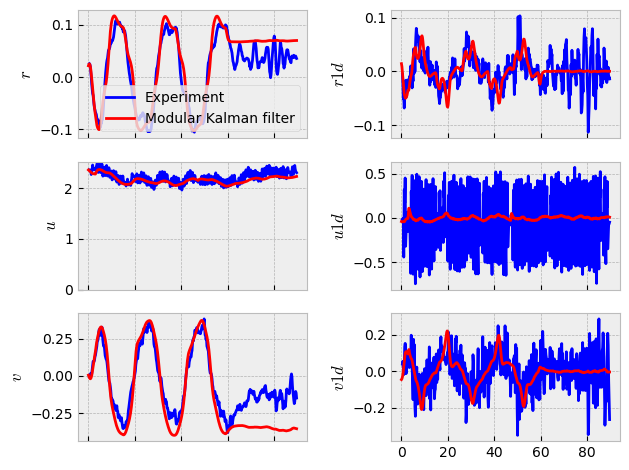

In [51]:
dataframes = {
    'Experiment':data.rolling(window=3).mean(),
    'Modular Kalman filter':ek.df_kalman,
    #'Modular Kalman smoother':ek.df_smooth,
    
}
plot(dataframes, keys=['u','v','r','u1d','v1d','r1d']);


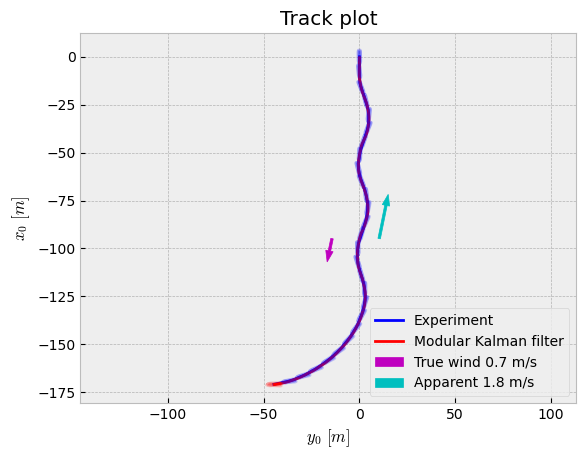

In [42]:
track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B']);

In [43]:
hull = model.subsystems['hull']
hull.partial_derivatives.keys()

dict_keys(['ddx_0X_H', 'ddy_0X_H', 'ddpsiX_H', 'dduX_H', 'ddvX_H', 'ddrX_H', 'ddx_0Y_H', 'ddy_0Y_H', 'ddpsiY_H', 'dduY_H', 'ddvY_H', 'ddrY_H', 'ddx_0N_H', 'ddy_0N_H', 'ddpsiN_H', 'dduN_H', 'ddvN_H', 'ddrN_H'])

In [44]:
rudders = model.subsystems['rudders']
rudders.partial_derivatives.keys()

dict_keys(['ddx_0X_R', 'ddy_0X_R', 'ddpsiX_R', 'dduX_R', 'ddvX_R', 'ddrX_R', 'ddx_0Y_R', 'ddy_0Y_R', 'ddpsiY_R', 'dduY_R', 'ddvY_R', 'ddrY_R', 'ddx_0N_R', 'ddy_0N_R', 'ddpsiN_R', 'dduN_R', 'ddvN_R', 'ddrN_R'])

In [45]:
propellers = model.subsystems['propellers']
propellers.partial_derivatives

{'ddx_0thrust': 0,
 'ddy_0thrust': 0,
 'ddpsithrust': 0,
 'dduthrust': D**2*n_prop*rho*(2*C0_w_p0**2*L*g*k_2*u + 4*C0_w_p0*C1_w_p0*U*k_2*u*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev - 4*C0_w_p0*L*g*k_2*u + 2*C1_w_p0**2*U**2*k_2*u - C1_w_p0*D*U*k_1*rev*sqrt(L*g) - 4*C1_w_p0*U*k_2*u*sqrt(L*g) + D*L*g*k_1*rev + 2*L*g*k_2*u)/(L*g),
 'ddvthrust': 0,
 'ddrthrust': 0,
 'ddx_0X_P': 0,
 'ddy_0X_P': 0,
 'ddpsiX_P': 0,
 'dduX_P': 0,
 'ddvX_P': 0,
 'ddrX_P': 0}

In [46]:
data.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,psi,phi,y_GPS,x_GPS,x0,y0,u,v,r,u1d,v1d,r1d,V,U,beta,aws,awa,tws,twa,global time,rev
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,3.1254,3.0809,2.3890,2.2867,4.9032,59.291708,18.324095,0.0167,-0.2836,2.3162,-1.8359,0.7009,-0.4434,1.8390,-2.3286,1.1035,100.0,3.1556,0.0111,-0.0174,-0.0038,0.0239,0.1161,-0.0719,-10.0339,-0.2213,2.4693,-1.5391,0.4420,-0.3703,2.0063,0.8051,-0.085577,3.1254,0.0167,334.376468,1387.282236,0.000000,0.000000,2.362019,-0.000006,0.025503,-0.032036,-0.070508,-0.015037,2.362019,2.362019,0.000002,2.23780,-0.29580,0.589474,1.173832,1673.979768,15
0.199978,3.1305,3.0848,2.3839,-7.7133,2.3508,59.291704,18.324095,0.0123,-0.2754,2.3279,-1.8013,0.6724,-0.4402,1.8517,-2.3184,1.0851,100.0,3.1556,0.0099,-0.0186,-0.0062,0.0273,0.0557,-0.3888,-9.8873,-0.1819,2.4693,-2.0971,0.3441,-0.3966,2.0063,0.8527,-0.041029,3.1305,0.0123,334.398158,1386.812662,-0.472290,0.007649,2.355613,-0.014106,0.022496,0.009295,0.049720,0.035010,2.355655,2.355655,0.005988,2.23780,-0.28925,0.570117,1.185571,1674.179746,15
0.400016,3.1350,3.0974,2.3812,-7.7133,-0.1755,59.291700,18.324095,0.0093,-0.2678,2.3386,-1.7685,0.6456,-0.4394,1.8634,-2.3079,1.0719,100.0,3.1556,0.0087,-0.0045,-0.0061,0.0275,0.1675,-0.1209,-9.9443,-0.1745,2.4693,-1.8664,0.3192,-0.4228,2.0063,0.8977,0.003063,3.1350,0.0093,334.418606,1386.343848,-0.943442,0.015698,2.357472,-0.004160,0.029499,-0.019771,0.139254,-0.034982,2.357476,2.357476,0.001765,2.23780,-0.29865,0.609754,1.200229,1674.379784,15
0.600022,3.1409,3.1115,2.3796,-7.7133,-2.7257,59.291696,18.324096,0.0103,-0.2619,2.3467,-1.7454,0.6249,-0.4379,1.8724,-2.3001,1.0599,100.0,3.1556,0.0075,0.0184,-0.0062,0.0191,0.1034,0.2364,-9.7616,-0.1871,2.4508,-1.6655,0.3597,-0.4237,1.9877,0.9161,0.047572,3.1409,0.0103,334.438820,1385.875335,-1.414935,0.019638,2.353518,0.023692,0.022503,-0.004625,-0.025749,-0.065019,2.353637,2.353637,-0.010066,2.21925,-0.30540,0.642986,1.194178,1674.579790,15
0.799999,3.1454,3.1310,2.3797,-7.7133,-5.3237,59.291691,18.324096,0.0136,-0.2575,2.3510,-1.7350,0.6100,-0.4349,1.8782,-2.2957,1.0484,100.0,3.1556,0.0066,0.0124,-0.0043,0.0059,-0.0346,0.0533,-9.7156,-0.2055,2.4063,-1.6502,0.4323,-0.3994,1.9490,0.9091,0.092916,3.1454,0.0136,334.446831,1385.406890,-1.885587,0.015227,2.352593,0.018542,0.009500,0.003771,-0.058634,-0.052503,2.352666,2.352666,-0.007882,2.17765,-0.30245,0.672899,1.155848,1674.779767,15


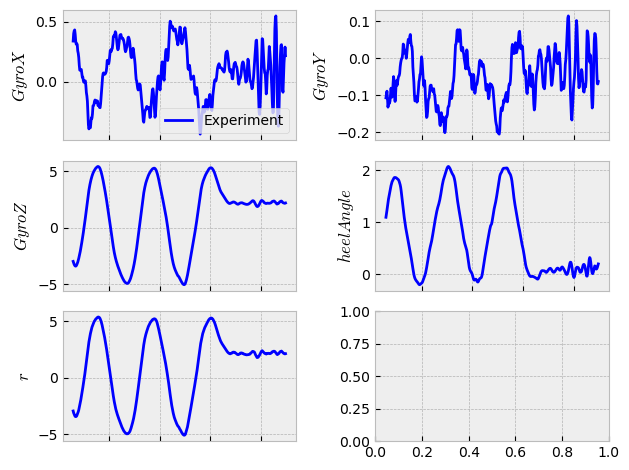

In [47]:
plot(dataframes={'Experiment':np.rad2deg(data.rolling(window=30).mean())}, keys=['GyroX','GyroY','GyroZ','r','heelAngle']); 	

<Axes: xlabel='time(us)'>

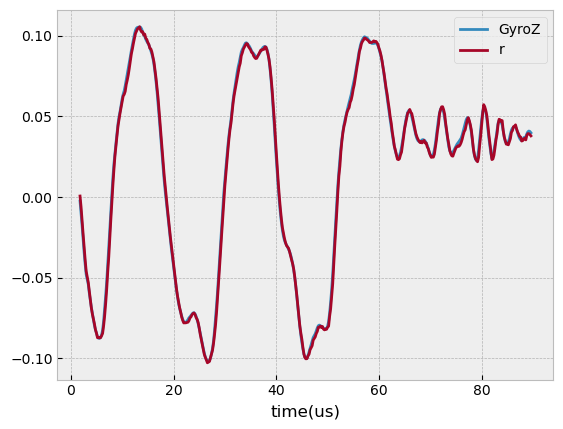

In [48]:
data.rolling(window=10).mean().plot(y=['GyroZ','r'])

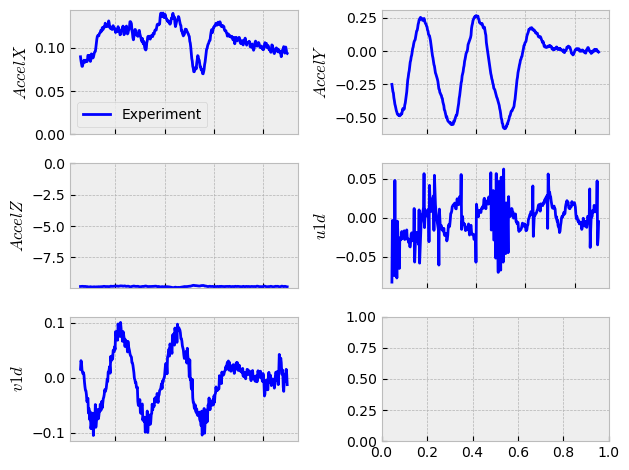

In [49]:
plot(dataframes={'Experiment':data.rolling(window=30).mean()}, keys=['AccelX','AccelY','AccelZ','u1d','v1d']); 

<Axes: xlabel='time(us)'>

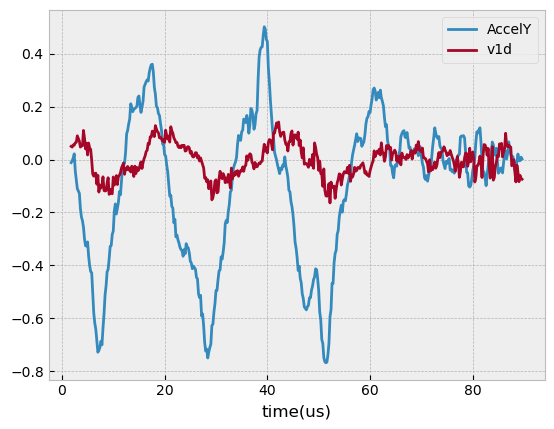

In [50]:
data.rolling(window=10).mean().plot(y=['AccelY','v1d'])